In [12]:
import os
os.environ.update({'KAPOHOBAY': '1'})

try:
    import nxsdk_modules_contrib.temporal_diff_enc.stde as stde
    from nxsdk_modules_contrib.temporal_diff_enc.stde import STDE_group
except ImportError: 
    import stde
    from stde import STDE_group

import nxsdk.api.n2a as nx
import numpy as np
%matplotlib inline

In [13]:
print(stde.__doc__)
print(STDE_group.__init__.__doc__)


This is a Loihi implementation of the spiking elementary motion detector (sEMD)/ temporal difference encoder (sTDE)
It converts a temporal difference between 2 spikes from different sources into a firing rate/ number of spikes

The sEMD has been introduced and used by:
- Milde, M. B., Bertrand, O. J., Ramachandran, H., Egelhaaf, M., & Chicca, E. (2018). Spiking elementary motion detector in neuromorphic systems. Neural computation, 30(9), 2384-2417.
- D'Angelo, G., Janotte, E., Schoepe, T., O'Keeffe, J., Milde, M. B., Chicca, E., & Bartolozzi, C. (2020). Event-based eccentric motion detection exploiting time difference encoding. Frontiers in Neuroscience, 14, 451.

This file was mainly written at the Telluride Neuromorphic Workshop 2019
by Alpha Renner (alpren@ini.uzh.ch)
Contributors:
Elisabetta Chicca
Garrick Orchard
Andreas Wild
Mike Davies

Version 1.3
Updated for nxsdk version 0.9.5



        The STDE_group contains the sTDE neurons.
        One neuron consists of 4 compartments

INFO:DRV:  Connecting to 127.0.0.1:39033
INFO:DRV:      Host server up..............Done 0.57s
INFO:DRV:      Encoding axons/synapses.....Done 3.51ms
INFO:DRV:      Compiling Embedded snips....Done 0.16s
INFO:DRV:      Compiling MPDS Registers....Done 0.29ms
INFO:DRV:      Booting up..................Done 2.18s
INFO:DRV:      Encoding probes.............Done 0.37ms
INFO:DRV:      Transferring probes.........Done 1.87ms
INFO:DRV:      Configuring registers.......Done 3.53ms
INFO:DRV:      Transferring spikes.........Done 1.32ms
INFO:DRV:      Executing...................Done 12.01s
INFO:DRV:      Processing timeseries.......Done 0.04s
INFO:DRV:  Executor: 3000 timesteps........Done 14.99s
INFO:HST:  Using Kapoho Bay serial number 446
INFO:HST:  Args chip=0 cpu=0 /home/giuliadangelo/workspace/code/nxsdk-apps-1.0.0/venv/lib/python3.7/site-packages/nxsdk/driver/compilers/../../../temp/1633960485.9364734/launcher_chip0_lmt0.bin --chips=1 --epoch=0 --remote-relay=0 
INFO:HST:  Nx...
INFO:HST

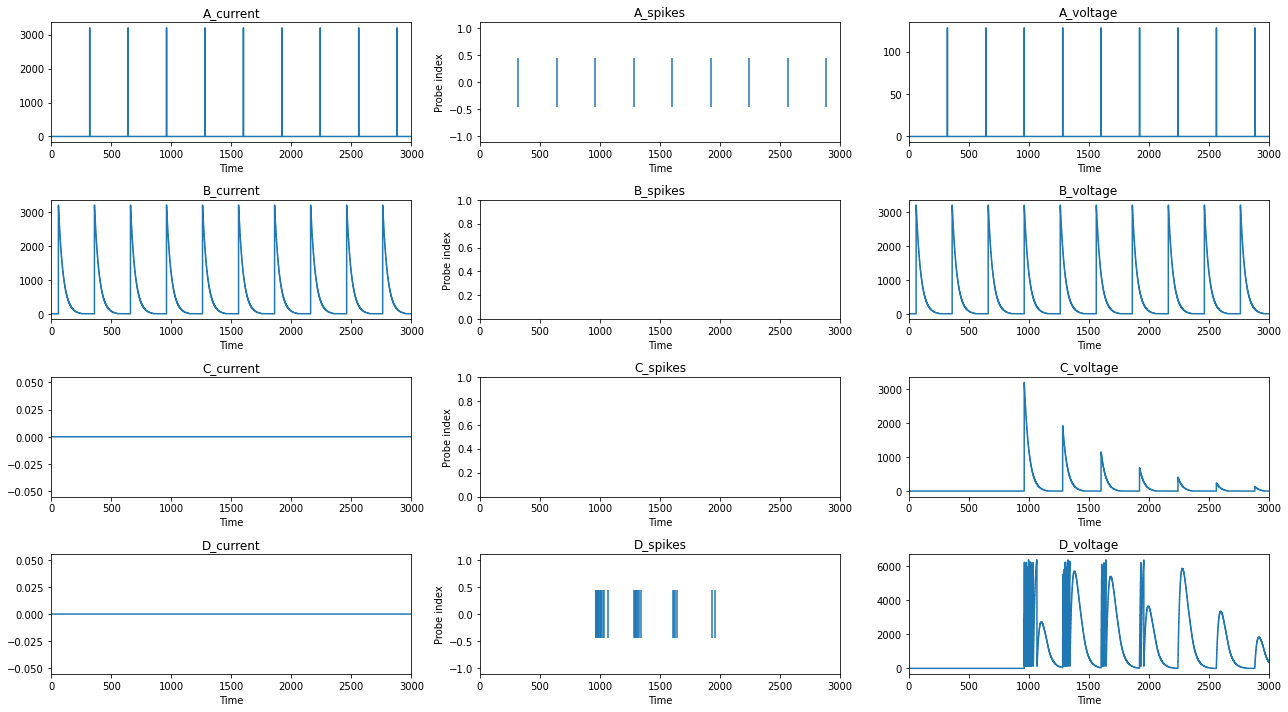

In [14]:
# Run a single tde neuron for 3000 timesteps and plot current, spikes and voltage for all compartments
# in order to understand the mechanism.
#
# As input, pairs of spikes to the trigger and the facilitator compartment are given.
# At first, the trigger is 60 ts before the facilitator, but the facilitator catches up by 20 ts after every trial.
# So the first two spikes do not elicity any tde output. The third, where both inputs spike at the same time, induces the largest tde output.
# After that the spikes are 20 ts apart and a lower output is elicited. For 40 ts, it is even lower and for 80 ts, no output is elicited anymore.
# This behavior can be changed by changing the parameters (which is explored in the following cells).

params = {'tau_fac': 40, # current tau of facilitator input
          'tau_trigg': 40, # current tau of trigger input
          'tau_v': 40, # voltage tau of TDE Neuron
          'tau_c': 40, # current tau of TDE Neuron
          'weight_fac': 2000, # amplitude of the facilitator spike
          'do_probes' : 'all', # can be 'all', 'spikes' or None
          'num_neurons' : 1,
         }

net = nx.NxNet()
# create the model with 1 neuron and plot
sTDE = STDE_group(params=params, net = net)

spike_times_fac = np.arange(60, 3000, 300).tolist()
spike_times_trigg = np.arange(0, 3000, 320).tolist()

indices_fac = np.zeros(len(spike_times_fac), dtype=int).tolist()
indices_trigg = np.zeros(len(spike_times_trigg), dtype=int).tolist()

sTDE.add_spikes(spike_times_trigg,indices_trigg,spike_times_fac,indices_fac)

# run the model
net.run(3000)
net.disconnect()

sTDE.plot()

In [ ]:
# create the network with 51 neurons and delta timesteps from -2 to +100 

num_neurons=51
params = {'tau_fac': 40, # current tau of facilitator input
          'tau_trigg': 40, # current tau of trigger input
          'tau_v': 40, # voltage tau of TDE Neuron
          'tau_c': 40, # voltage tau of TDE Neuron
          'weight_fac': 4000, # amplitude of the facilitator spike
          'do_probes' : 'all', # can be 'all', 'spikes' or None
          'num_neurons' : num_neurons,
         }


net = nx.NxNet()
sTDE = STDE_group(params=params, net = net)

spike_times_fac = [100]*num_neurons
spike_times_trigg = [98+ii*2 for ii in range(num_neurons)]

indices_trigg = np.arange(0,num_neurons, dtype=int).tolist()
indices_fac = np.arange(0,num_neurons, dtype=int).tolist()

sTDE.add_spikes(spike_times_trigg,indices_trigg,spike_times_fac,indices_fac)

# run the model
net.run(300)
net.disconnect()

sTDE.plot()
plt.tight_layout()
plt.show()

spikes = np.sum(sTDE.probes['D_spikes'].data,1)

plt.figure()
plt.plot(np.asarray(spike_times_trigg)-100, spikes)
plt.xlabel('delta t')
plt.ylabel('num spikes')
plt.tight_layout()
plt.show()

In [ ]:
# Explore the effect of the facilitator time constant

taus = [10,20,30,40,50,60,70,80,100,150,200]

#every neuron gets a different dt (per group)
num_neurons = 50

spike_times_fac = [100]*num_neurons
spike_times_trigg = [70+ii*5 for ii in range(num_neurons)]

indices_fac = np.arange(0,num_neurons, dtype=int).tolist()
indices_trigg = np.arange(0,num_neurons, dtype=int).tolist()

net = nx.NxNet()

sTDEs = {}

for tau in taus:
    params = {'tau_fac': tau, # current tau of facilitator input
          'tau_trigg': 40, # current tau of trigger input
          'tau_v': 40, # voltage tau of TDE Neuron
          'tau_c': 40, # voltage tau of TDE Neuron
          'weight_fac': 2000, # amplitude of the facilitator spike
          'do_probes' : 'all', # can be 'all', 'spikes' or None
          'num_neurons' : num_neurons,
         }
    sTDEs[tau] = STDE_group(params=params, net = net)
    sTDEs[tau].add_spikes(spike_times_trigg,indices_trigg,spike_times_fac,indices_fac)

# run the model
net.run(300)
net.disconnect()

spikes = {}
plt.figure()
for tau in taus:
    spikes[tau] = np.sum(sTDEs[tau].probes['D_spikes'].data,1)
    plt.plot(np.asarray(spike_times_trigg)-100, spikes[tau])

plt.xlabel('\delta t (ts)')
plt.ylabel('num spikes')
plt.legend(['tau facilitator='+str(tau) for tau in taus])


In [ ]:
# Explore the effect of the trigger time constant

taus = [10,20,30,40,50,60,70,80,100,150,200]

#every neuron gets a different dt (per group)
num_neurons = 50

spike_times_fac = [100]*num_neurons
spike_times_trigg = [70+ii*5 for ii in range(num_neurons)]

indices_fac = np.arange(0,num_neurons, dtype=int).tolist()
indices_trigg = np.arange(0,num_neurons, dtype=int).tolist()

net = nx.NxNet()

sTDEs = {}

for tau in taus:
    params = {'tau_fac': 40, # current tau of facilitator input
          'tau_trigg': tau, # current tau of trigger input
          'tau_v': 40, # voltage tau of TDE Neuron
          'tau_c': 40, # voltage tau of TDE Neuron
          'weight_fac': 2000, # amplitude of the facilitator spike
          'do_probes' : 'all', # can be 'all', 'spikes' or None
          'num_neurons' : num_neurons,
         }
    sTDEs[tau] = STDE_group(params=params, net = net)
    sTDEs[tau].add_spikes(spike_times_trigg,indices_trigg,spike_times_fac,indices_fac)

# run the model
net.run(300)
net.disconnect()

spikes = {}
plt.figure()
for tau in taus:
    spikes[tau] = np.sum(sTDEs[tau].probes['D_spikes'].data,1)
    plt.plot(np.asarray(spike_times_trigg)-100, spikes[tau])

plt.xlabel('\delta t (ts)')
plt.ylabel('num spikes')
plt.legend(['tau trigger='+str(tau) for tau in taus])


In [ ]:
# Explore the effect of the facilitator weight

pars = [500,1000,1500,2000,2500,3000,3500,4000,5000,6000,7000,8000,9000,10000]

#every neuron gets a different dt (per group)
num_neurons = 50

spike_times_fac = [100]*num_neurons
spike_times_trigg = [70+ii*5 for ii in range(num_neurons)]

indices_fac = np.arange(0,num_neurons, dtype=int).tolist()
indices_trigg = np.arange(0,num_neurons, dtype=int).tolist()

net = nx.NxNet()

sTDEs = {}

for par in pars:
    params = {'tau_fac': 40, # current tau of facilitator input
          'tau_trigg': 40, # current tau of trigger input
          'tau_v': 40, # voltage tau of TDE Neuron
          'tau_c': 40, # voltage tau of TDE Neuron
          'weight_fac': par, # amplitude of the facilitator spike
          'do_probes' : 'all', # can be 'all', 'spikes' or None
          'num_neurons' : num_neurons,
         }
    sTDEs[par] = STDE_group(params=params, net = net)
    sTDEs[par].add_spikes(spike_times_trigg,indices_trigg,spike_times_fac,indices_fac)

# run the model
net.run(300)
net.disconnect()

spikes = {}
plt.figure()
for par in pars:
    spikes[par] = np.sum(sTDEs[par].probes['D_spikes'].data,1)
    plt.plot(np.asarray(spike_times_trigg)-100, spikes[par])

plt.xlabel('\delta t (ts)')
plt.ylabel('num spikes')
plt.legend(['weight='+str(par) for par in pars])
